In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
import pandas as pd 
import matplotlib.pyplot as plt

from dln import (
    create_dln_model, 
    create_minibatches, 
    true_dln_learning_coefficient, 
    mse_loss, 
)
from sgld_utils import (
    SGLDConfig, 
    run_sgld, 
    run_sgld_known_potential
)
from utils import to_json_friendly_tree, running_mean



import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import seaborn as sns

import os

datetime_str = pd.Timestamp.now().strftime("%Y%m%d")
IMAGEDIR = f"./images/stagewise_dln_plots/plots_{datetime_str}/"
DRYRUN = False
OPEN_SAVEDIMAGES = False

os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return



def estimate_cross_correlation_matrix(X, Y):
    # Ensure X and Y have the same number of samples
    assert X.shape[0] == Y.shape[0], "X and Y must have the same number of samples"
    
    n = X.shape[0]
    
    # Compute the non-centered cross covariance matrix
    C_XY = np.dot(X.T, Y) / n
    
    return C_XY




def generate_correlation_matrix(key, n):
    """
    Generate a random positive definite symmetric square matrix.
    
    :param key: JAX random key
    :param n: The size of the matrix (n x n)
    :return: A random positive definite symmetric square matrix
    """
    key, subkey = jax.random.split(key)
    A = jax.random.uniform(subkey, (n, n))
    B = jnp.dot(A, A.T)
    C = B / jnp.max(jnp.abs(B))  # Normalize to ensure diagonal elements are 1
    return (C + C.T) / 2  # Ensure perfect symmetry

def generate_correlated_data(key, n_samples, correlation_matrix):
    """
    Generate data with a specified correlation structure using JAX multivariate normal.
    
    :param key: JAX random key
    :param n_samples: Number of samples to generate
    :param correlation_matrix: The desired correlation matrix
    :return: Generated data with the specified correlation structure
    """
    n_features = correlation_matrix.shape[0]
    mean = jnp.zeros(n_features)
    return jax.random.multivariate_normal(key, mean, correlation_matrix, (n_samples,))


def make_potential_fn(teacher_matrix, feature_corr, feature_output_cross_correlation, layer_widths):
    eigvals, eigvecs = np.linalg.eigh(feature_corr)
    ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-1/2)) @ eigvecs.T
    modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis 
    U, S, V = np.linalg.svd(modified_feature_output_cross_correlation)
    V = V.T
    Vhat = np.linalg.inv(ChangeOfBasis) @ V
    def get_matrices():
        return U, S, V, Vhat, ChangeOfBasis

    def potential_matrix_fn(param):
        total_matrix = jnp.linalg.multi_dot(
            [
                jnp.array(param[f'deep_linear_network/linear{loc}']['w']) 
                for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
            ]
        )
        potential_matrix = U.T @ (total_matrix.T - teacher_matrix) @ Vhat
        return potential_matrix
    
    def potential_fn(param):
        potential_matrix = potential_matrix_fn(param)
        return jnp.sum(potential_matrix ** 2)
    return potential_matrix_fn, potential_fn, get_matrices



def set_axis_ylim(ax, ymin_bound=None, ymax_bound=None):
    ymin, ymax = ax.get_ylim()
    if ymin_bound is not None:
        ymin = max(ymin, ymin_bound)
    if ymax_bound is not None:
        ymax = min(ymax, ymax_bound)
    ax.set_ylim(ymin, ymax)
    return ymin, ymax

    


In [2]:
use_idcorr = True
initorigin = True
use_behavioural = True


expt_name = f"stagewise_dln_idcorr{use_idcorr}_initorigin{initorigin}"
do_llc_estimation = True
in_out_dim = 5
sgld_config = {
        'epsilon': 5e-8,
        'gamma': 1.0,
        'num_steps': 500,
        "num_chains": 1, 
        "batch_size": 512
    }
loss_trace_minibatch = True
burn_in_prop = 0.9

width = in_out_dim
if initorigin:
    initialisation_exponent = 2.0
else: 
    initialisation_exponent = -1.0

num_hidden_layers = 3
num_training_data = 10000
itemp = 1 / np.log(num_training_data)
training_config = {
    "optim": "sgd", 
    "learning_rate": 1e-4, 
    "momentum": None, 
    "batch_size": 128, 
    "num_steps": 250000
}
seed = 42
logging_period = 200
verbose = True
output_noise_std = 0.1

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

####################
# Initialisations
####################
# Teacher matrix
# teacher_matrix = np.diag([180, 60, 20])
# teacher_matrix = 10 * np.diag(np.arange(in_out_dim, stop=0, step=-1))
teacher_matrix = np.diag([50, 40, 30, 20, 10])
# teacher_matrix = np.diag([500, 200, 100, 50, 10])
# teacher_matrix = np.diag([500, 40, 30, 20, 10])


feature_dim = teacher_matrix.shape[0]
output_dim = teacher_matrix.shape[1]
layer_widths = [width] * num_hidden_layers + [output_dim]

# Training data from teacher matrix
rngkey, rngkey = jax.random.split(rngkey)
if use_idcorr:
    feature_corr = np.eye(feature_dim)
else:
    feature_corr = generate_correlation_matrix(rngkey, feature_dim)
x_train = jax.random.multivariate_normal(
    rngkey, 
    jnp.zeros(feature_dim), 
    feature_corr, 
    shape=(num_training_data,), 
    dtype=jnp.float32
)

rngkey, rngkey = jax.random.split(rngkey)
y_train = x_train @ teacher_matrix + jax.random.normal(rngkey, shape=(num_training_data, output_dim)) * output_noise_std

# DLN model
initialisation_sigma = np.sqrt(width ** (-initialisation_exponent))
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))


rngkey, subkey = jax.random.split(rngkey)
param_init = model.init(rngkey, jnp.zeros((1, feature_dim)))
# param_init = jtree.tree_map_with_path(
#     lambda path, x: x * 0.0 if "linear_1" in path[0].key else x, 
#     param_init
# )
# init_param = jtree.tree_map(lambda x: x * 0.0, init_param)
# init_param = jtree.tree_map(lambda x: x + jnp.diag(np.random.randn(len(np.diag(x))) * 0.05), init_param)



print("Model initialised with shapes:")
jtree.tree_map(lambda x: print(x.shape), param_init)

##############################################
# Train the model and do SGLD at some interval
##############################################

sgld_config = SGLDConfig(**sgld_config)

optimizer = optax.sgd(learning_rate=training_config["learning_rate"])
max_steps = training_config["num_steps"]
t = 0
rngkey, subkey = jax.random.split(rngkey)
grad_fn = jax.jit(jax.value_and_grad(loss_fn, argnums=0))
trained_param = param_init
opt_state = optimizer.init(trained_param)

input_output_correlation_matrix = (x_train.T @ y_train) / num_training_data
input_correlation_matrix = (x_train.T @ x_train) / num_training_data



info = []
while t < max_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        train_loss, grads = grad_fn(trained_param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        trained_param = optax.apply_updates(trained_param, updates)
        
        
        if t % logging_period == 0:
                
            rec = {
                "t": t + 1, 
                "train_loss": float(train_loss),
                "trained_param": trained_param,
            }
            
            if do_llc_estimation:
                rngkey, subkey = jax.random.split(rngkey)
                y_realisable = model.apply(trained_param, x_train) #+ jax.random.normal(subkey, shape=(num_training_data, output_dim)) * output_noise_std
                if use_behavioural:
                    y = y_realisable
                else: 
                    y = y_train

                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    trained_param, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=loss_trace_minibatch, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                trace_start = min(int(burn_in_prop * len(loss_trace)), len(loss_trace) - 1)
                init_loss = loss_fn(trained_param, x_train, y)
                lambdahat = float(np.mean(loss_trace[trace_start:]) - init_loss) * num_training_data * itemp

                true_matrix = jnp.linalg.multi_dot(
                    [trained_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
                )
                # true_rank = jnp.linalg.matrix_rank(true_matrix)
                true_rank = np.sum(np.abs(np.linalg.eigvals(true_matrix)) > 1e-1)
                true_lambda, true_multiplicity = true_dln_learning_coefficient(
                    true_rank, 
                    layer_widths, 
                    feature_dim, 
                )
            
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        "true_lambda": true_lambda, 
                        "true_multiplicity": true_multiplicity, 
                        "loss_trace": loss_trace, 
                        "true_rank": true_rank,
                        "init_loss": float(init_loss),
                    }
                )
            if verbose and t % logging_period == 0:
                print(
                    f"t: {t + 1}, "
                    + f"train_loss: {float(train_loss):.4f}, "
                    + (f"lambdahat: {lambdahat:.4f}, " if do_llc_estimation else "")
                    + (f"true_lambda: {true_lambda:.4f}, " if do_llc_estimation else "")
                    + (f"true_rank: {true_rank}, " if do_llc_estimation else "")
                )

            info.append(to_json_friendly_tree(rec))
        
        t += 1
        if t >= max_steps:
            break


Model initialised with shapes:
(5, 5)
(5, 5)
(5, 5)
(5, 5)
t: 1, train_loss: 1025.6738, lambdahat: 0.0008, true_lambda: 8.0000, true_rank: 0, 
t: 201, train_loss: 1103.3358, lambdahat: 0.0031, true_lambda: 8.0000, true_rank: 0, 
t: 401, train_loss: 1084.9945, lambdahat: 0.0015, true_lambda: 8.0000, true_rank: 0, 
t: 601, train_loss: 1036.1835, lambdahat: 0.0021, true_lambda: 8.0000, true_rank: 0, 
t: 801, train_loss: 1002.2482, lambdahat: 0.0029, true_lambda: 8.0000, true_rank: 0, 
t: 1001, train_loss: 1128.9235, lambdahat: 0.0058, true_lambda: 9.5000, true_rank: 1, 
t: 1201, train_loss: 1180.1796, lambdahat: 0.0106, true_lambda: 9.5000, true_rank: 1, 
t: 1401, train_loss: 1098.3942, lambdahat: 0.0323, true_lambda: 11.0000, true_rank: 2, 
t: 1601, train_loss: 1072.1139, lambdahat: 0.0721, true_lambda: 11.0000, true_rank: 2, 
t: 1801, train_loss: 757.3651, lambdahat: 2.6571, true_lambda: 11.0000, true_rank: 2, 
t: 2001, train_loss: 573.4335, lambdahat: 3.5428, true_lambda: 11.0000, true

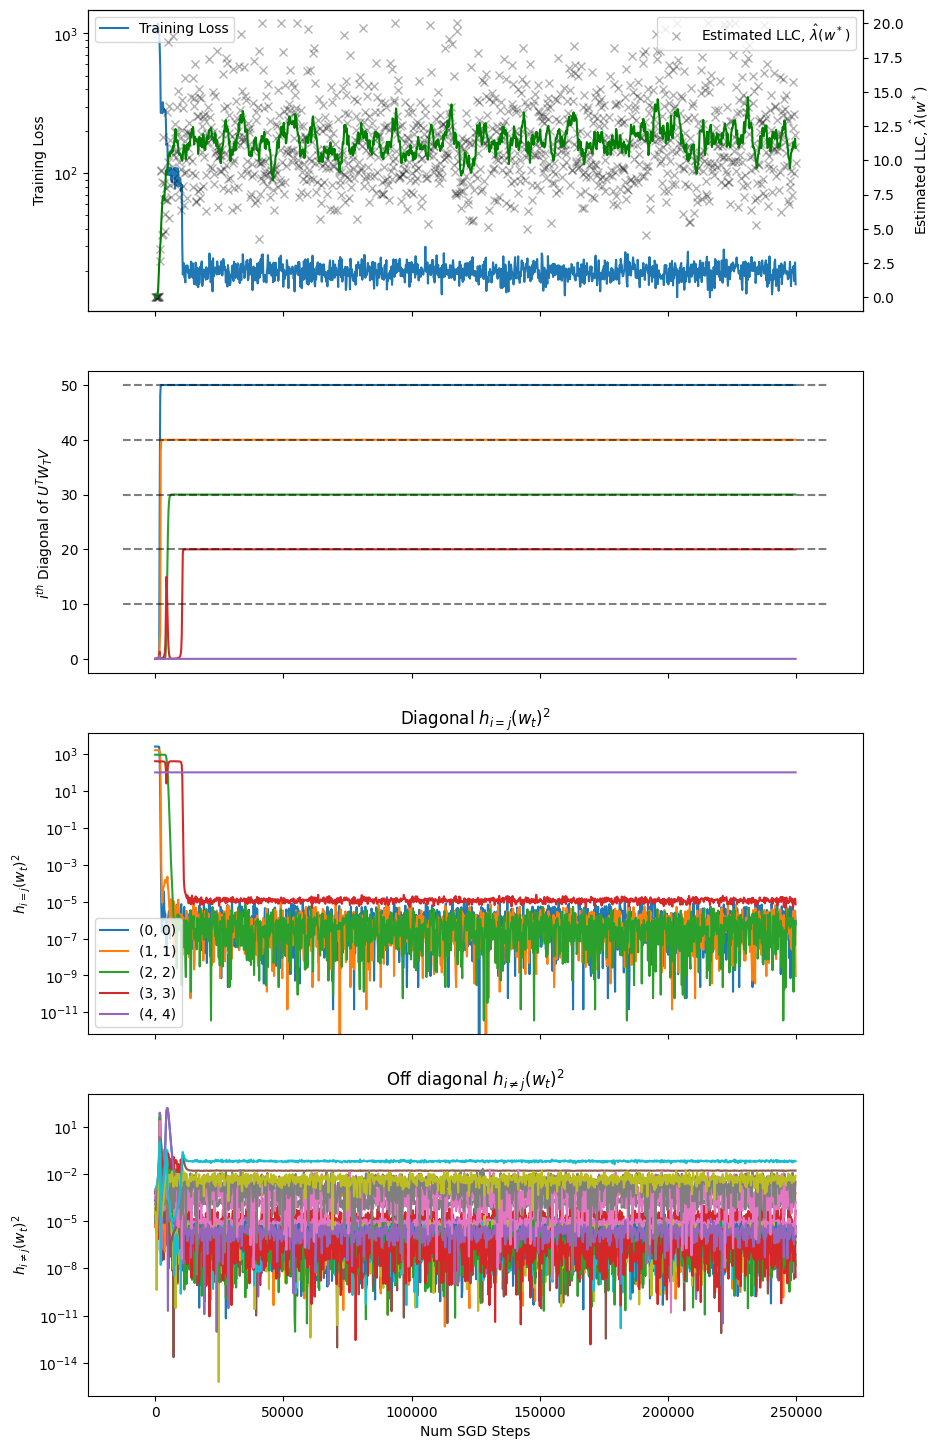

In [3]:
df_sgd = pd.DataFrame(info)
df = df_sgd
df["total_matrix"] = [
        jnp.linalg.multi_dot(
            [
                jnp.array(param[f'deep_linear_network/linear{loc}']['w']) 
                    for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]
            ]
        ) for param in df["trained_param"]
]


# feature_output_cross_correlation = y_train.T @ x_train / num_training_data
feature_output_cross_correlation = teacher_matrix @ feature_corr
potential_matrix_fn, potential_fn, get_matrices = make_potential_fn(
    teacher_matrix, 
    feature_corr, 
    feature_output_cross_correlation, 
    layer_widths=layer_widths
)

U, S, V, Vhat, ChangeOfBasis = get_matrices()
df["corrected_total_matrix"] = df["total_matrix"].apply(
    lambda w: U.T @ w.T @ Vhat
)
df["corrected_total_matrix_diagonals"] = df["corrected_total_matrix"].apply(
    # lambda x: np.linalg.svd(x)[1]
    lambda x: np.diag(x)
)

df["potential_matrix"] = df["trained_param"].apply(potential_matrix_fn)
df["potential"] = df["trained_param"].apply(potential_fn)


fig, axes = plt.subplots(4, 1, figsize=(10, 18), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    clipped_llc = np.clip(df["lambdahat"], a_min=0, a_max=20)
    ax.plot(df["t"], clipped_llc, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(clipped_llc)
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")


ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")



ax = axes[2]
for i in range(input_output_correlation_matrix.shape[0]):
    yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
    ax.plot(df["t"], yvals, label=f"({i}, {i})")
ax.set_ylabel("$h_{i=j}(w_t)^2$")
ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
ax.legend()
ax.set_yscale("log")

ax = axes[3]
for i in range(input_output_correlation_matrix.shape[0]):
    for j in range(input_output_correlation_matrix.shape[1]):
        if i == j: continue # only plot the off diagonal elements
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {j})")
ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
ax.set_yscale("log")
# ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable


def visualize_pca_trajectory(
        transformed_trajectory, 
        axes,
        cmap="magma", 
        logscale_colorbar=False, 
        logscale_hist=False, 
        add_cbar=True
    ):
    # Create a normalization for the colormap
    if logscale_colorbar:
        norm = LogNorm(1, len(transformed_trajectory) - 1)
    else:
        norm = plt.Normalize(0, len(transformed_trajectory) - 1)
    
    # Plot each PCA component pair
    k = transformed_trajectory.shape[1]
    for i in range(k):
        for j in range(k):
            
            ax = axes[i, j]  # Reverse the vertical order
            
            if i == j:  # Diagonal - plot histogram
                ax.hist(transformed_trajectory[:, i], bins=30, alpha=0.7)
                ax.set_title(f'PC{i+1} Distribution')
                if logscale_hist:
                    ax.set_yscale('log')
            elif i < j:  # Upper triangle - remove these plots
                ax.axis('off')
            else:  # Lower triangle - plot scatter
                pcy = k - i + j
                pcx = j
                scatter = ax.scatter(
                    transformed_trajectory[:, pcx], 
                    transformed_trajectory[:, pcy], 
                    c=list(range(len(transformed_trajectory))), 
                    cmap=cmap, 
                    norm=norm, 
                    alpha=0.6, 
                    s=30, 
                    edgecolor='none'
                )
                ax.plot(transformed_trajectory[:, pcx], transformed_trajectory[:, pcy], color='gray', alpha=0.1, linewidth=1)
                
                ax.set_xlabel(f'PC{pcx + 1}')
                ax.set_ylabel(f'PC{pcy + 1}')

    if add_cbar:
        cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
        cbar = fig.colorbar(scatter, cax=cax, label='Time')
        # cbar.set_ticks(range(0, len(pca_trajectory) - 1, len(pca_trajectory) // 5))
        # cbar.set_ticklabels(['Start', 'End'])
        
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar
    return



def visualize_pca_trajectory_3d(transformed_trajectory, ax, cmap="magma", logscale_colorbar=False, add_cbar=True):
    # Create a normalization for the colormap
    if logscale_colorbar:
        norm = LogNorm(1, len(transformed_trajectory) - 1)
    else:
        norm = plt.Normalize(0, len(transformed_trajectory) - 1)
    
    # Plot the trajectory
    scatter = ax.scatter(
        transformed_trajectory[:, 0], 
        transformed_trajectory[:, 1], 
        transformed_trajectory[:, 2],
        c=range(len(transformed_trajectory)), 
        cmap=cmap, 
        norm=norm,
        alpha=0.6, 
        s=30, 
        edgecolor='none'
    )
    
    # Plot a line connecting the points
    ax.plot(
        transformed_trajectory[:, 0], 
        transformed_trajectory[:, 1], 
        transformed_trajectory[:, 2],
        color='gray', 
        alpha=0.3, 
        linewidth=1
    )
    
    # Set labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('3D PCA Trajectory Visualization')
    # Improve the viewing angle
    ax.view_init(elev=20, azim=45)
    
    
    if add_cbar:
        cbar = fig.colorbar(scatter, ax=ax, label='Time', aspect=5)
        # cbar.set_ticks([0, len(pca_trajectory) - 1])
        # cbar.set_ticklabels(['Start', 'End'])

    plt.tight_layout()
    return

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91487/3846781385.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


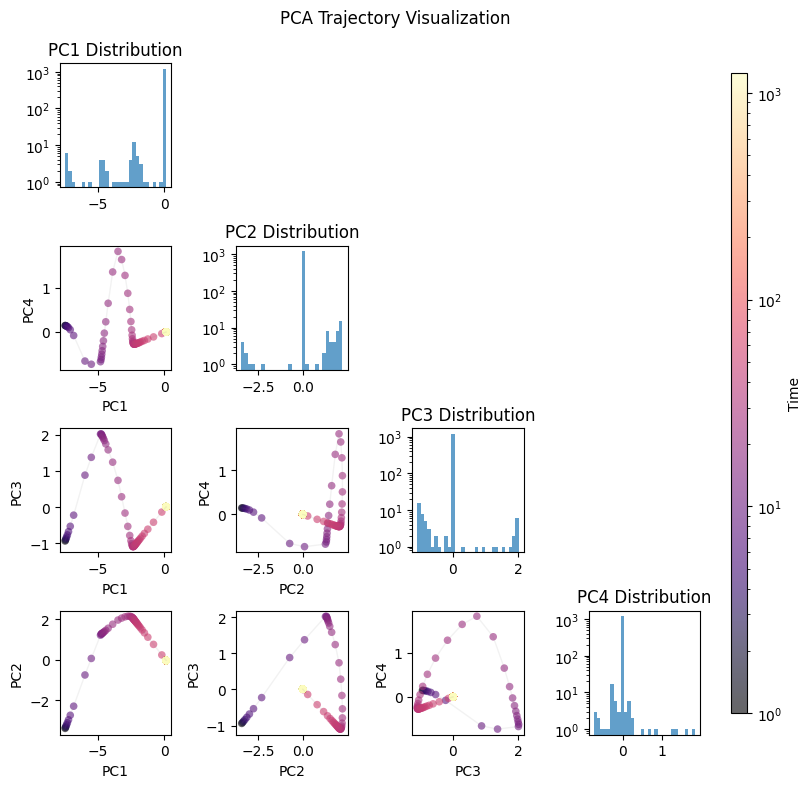

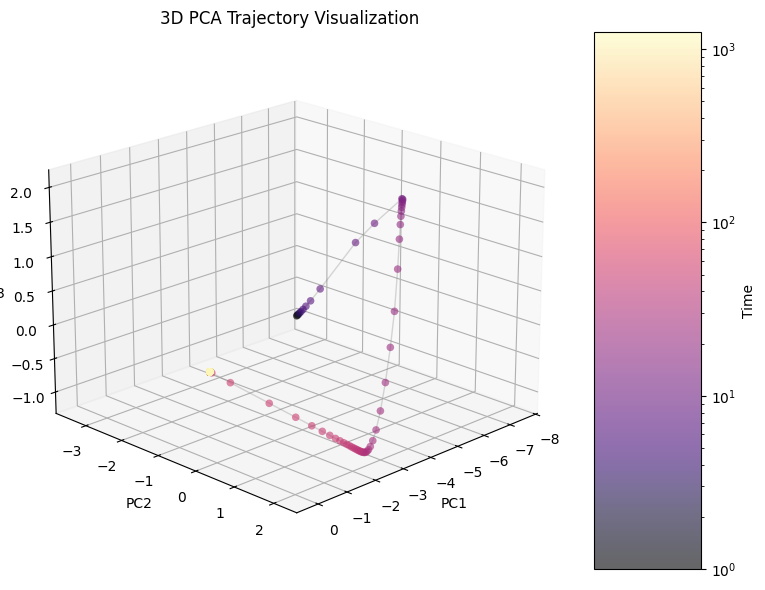

In [5]:
param_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df["trained_param"]])
k = 4
pca = PCA(n_components=k)
transformed_trajectory = pca.fit_transform(param_trajectory)
figsize_factor = 2
fig, axes = plt.subplots(k, k, figsize=(figsize_factor*k, figsize_factor*k))
fig.suptitle("PCA Trajectory Visualization")
visualize_pca_trajectory(transformed_trajectory, axes, logscale_colorbar=True, logscale_hist=True, add_cbar=True)

# Create the 3D plot
figsize=(8, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
visualize_pca_trajectory_3d(transformed_trajectory, ax, logscale_colorbar=True)

In [6]:

def gradient_flow(
        potential_fn, 
        initial_params, 
        num_steps, 
        learning_rate=1e-3, 
        logging_period=100, 
        verbose=False, 
        early_stopping_epsilon=None,
        min_num_steps=None
    ):
    """
    Perform gradient flow on the given potential function.
    
    :param potential_fn: The potential function to optimize (should take params as input and return a scalar)
    :param initial_params: Initial parameters (can be a pytree)
    :param num_steps: Number of optimization steps
    :param learning_rate: Learning rate for the gradient descent (default: 1e-3)
    :return: Tuple of (optimized parameters, loss history)
    """
    # Create an optimizer
    optimizer = optax.sgd(learning_rate)
    
    # Initialize the optimizer state
    opt_state = optimizer.init(initial_params)
    
    # Compute the gradient of the potential function
    grad_fn = jax.grad(potential_fn)
    
    # Define a single step of the optimization
    @jax.jit
    def step(params, opt_state):
        loss = potential_fn(params)
        grads = grad_fn(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    # Initialize parameters and loss history
    params = initial_params
    records = []

    # Run the optimization loop
    for t in range(num_steps):
        params, opt_state, loss = step(params, opt_state)
        if t % logging_period == 0:
            rec = {
                "t": t,
                "params": params,
                "loss": float(loss)
            }
            records.append(to_json_friendly_tree(rec))
            if verbose: 
                print(t, float(loss))

            if not jnp.isfinite(loss):
                print("Loss is not finite. Stopping the optimization.")
                break

            if early_stopping_epsilon is not None and loss < early_stopping_epsilon:
                if min_num_steps is None or t >= min_num_steps:
                    print(f"LOSS BELOW EARLY STOPPING EPSILON. STOPPING EARLY. t={t}")
                    break
                
    if t % logging_period != 0: # Log the final step
        rec = {
            "t": t,
            "params": params,
            "loss": float(loss)
        }
        records.append(to_json_friendly_tree(rec))
    return records



flow_rec = gradient_flow(
    potential_fn, 
    param_init, 
    training_config["num_steps"], 
    learning_rate=training_config["learning_rate"] / 5, 
    logging_period=logging_period
)

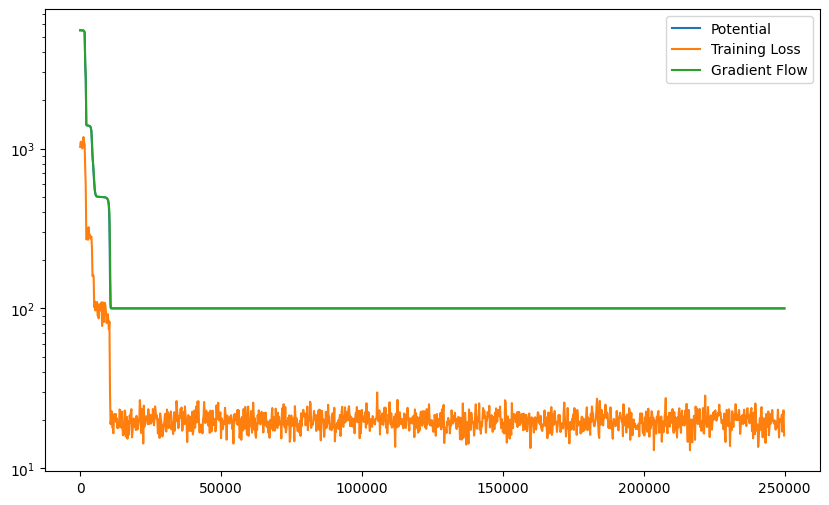

In [7]:
df_flow = pd.DataFrame(flow_rec)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(df["t"], df["potential"], label="Potential")
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.plot(df_flow["t"], df_flow["loss"], label="Gradient Flow")
ax.set_yscale("log")
ax.legend()

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91487/3846781385.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


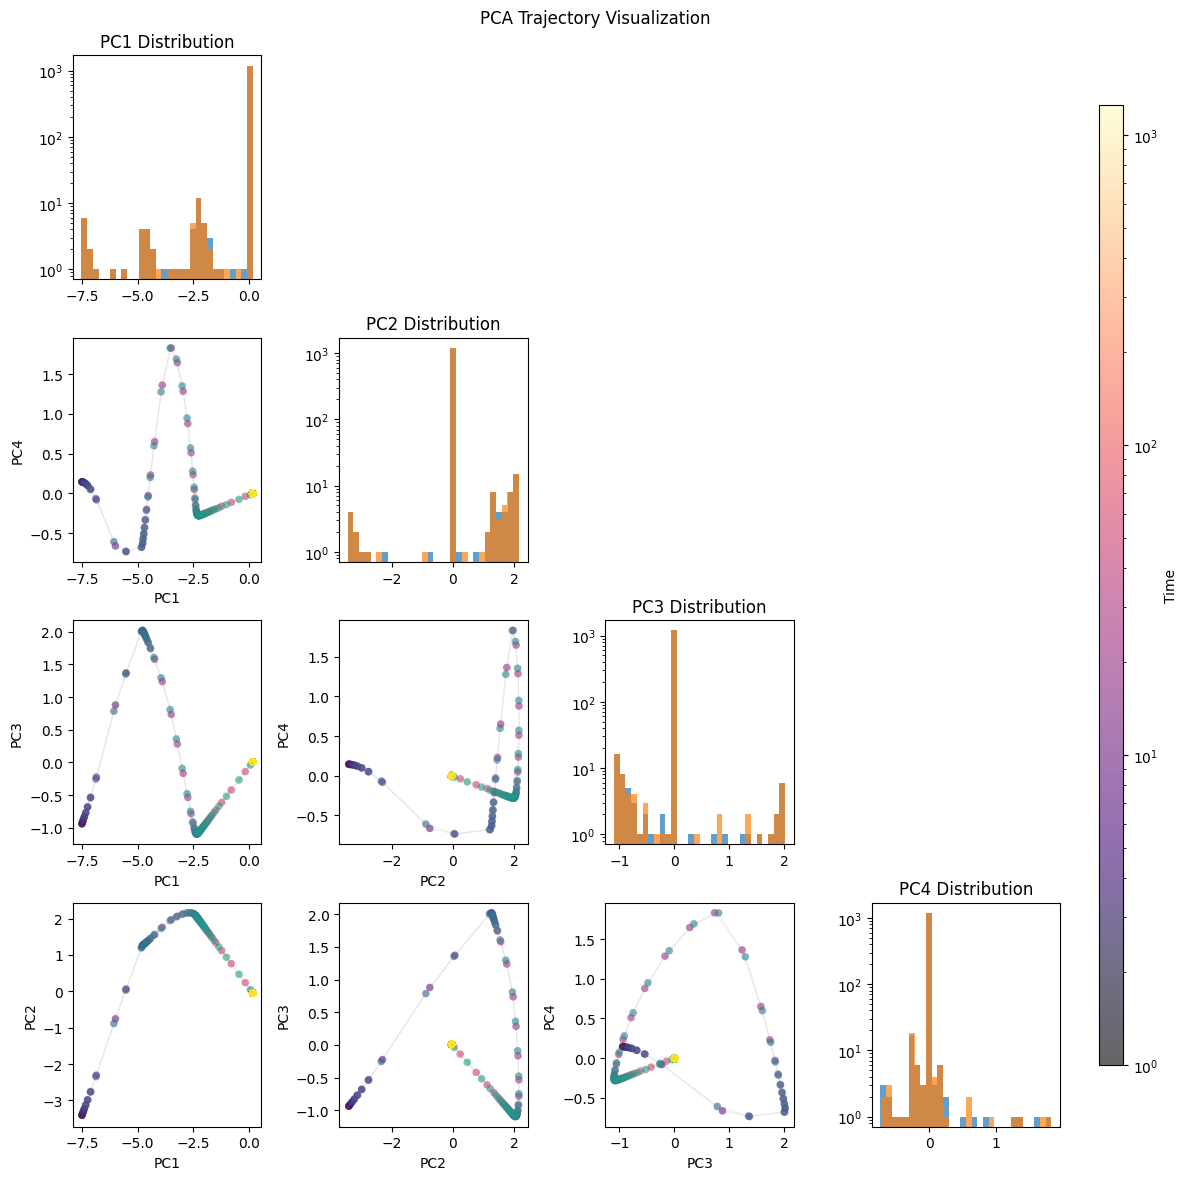

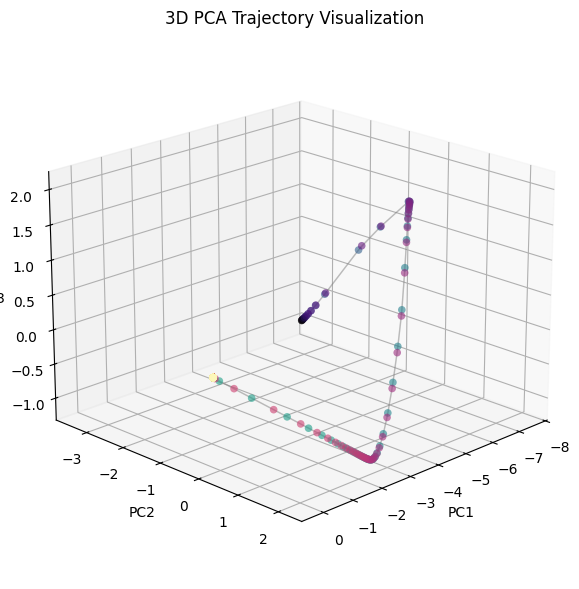

In [8]:
flow_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df_flow["params"]])
param_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df["trained_param"]])

k = 4
pca = PCA(n_components=k)
transformed_trajectory = pca.fit_transform(param_trajectory)
transformed_flow_trajectory = pca.transform(flow_trajectory)
figsize_factor = 3
fig, axes = plt.subplots(k, k, figsize=(figsize_factor*k, figsize_factor*k))
fig.suptitle("PCA Trajectory Visualization")
visualize_pca_trajectory(transformed_trajectory, axes, logscale_colorbar=True, logscale_hist=True)
visualize_pca_trajectory(transformed_flow_trajectory, axes, logscale_colorbar=True, logscale_hist=True, add_cbar=False, cmap="viridis")




# Create the 3D plot
figsize=(8, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
visualize_pca_trajectory_3d(transformed_trajectory, ax, logscale_colorbar=True, add_cbar=False)
visualize_pca_trajectory_3d(transformed_flow_trajectory, ax, logscale_colorbar=True, add_cbar=False, cmap="viridis")

# Stage-wise training

In [9]:

stage_potential_fn_list = []
U, S, V, Vhat, ChangeOfBasis = get_matrices()
for i in range(feature_dim):
    def stage_potential_fn(param):
        H = potential_matrix_fn(param)**2
        return jnp.sum(H[:i + 1, :i + 1])

    # stage_potential_fn = lambda param: jnp.sum(
    #     jnp.diag(potential_matrix_fn(param))[:i + 1]**2
    # )

    stage_potential_fn = jax.jit(stage_potential_fn)
    stage_potential_fn_list.append(stage_potential_fn)

# stage_potential_fn_list.append(
#     jax.jit(
#         lambda param: jnp.sum(potential_matrix_fn(param)**2)
#     )
# )



early_stopping_epsilon = 1e-7
min_num_steps = 2000
max_num_steps = training_config["num_steps"] * 2
learning_rate = training_config["learning_rate"]
param = param_init
# param = jtree.tree_map(lambda x: x * 0.0, param)
# param = jtree.tree_map(lambda x: x + jnp.diag(np.random.rand(len(np.diag(x))) * 0.01), param)
jtree.tree_map(lambda x: print(x), param)

current_steps = 0
logging_period = 100
curr_steps = []

stage_meta_rec = []
stage_flow_rec = []
for i, stage_potential_fn in enumerate(stage_potential_fn_list):
    meta_rec = {
            "stage": i + 1,
            "init_param": param,
            "potential_fn": stage_potential_fn,
        }
    record = gradient_flow(
        stage_potential_fn, 
        param, 
        max_num_steps, 
        learning_rate=learning_rate, 
        logging_period=logging_period, 
        early_stopping_epsilon=early_stopping_epsilon, 
        verbose=False, 
        min_num_steps=min_num_steps,
    )
    meta_rec["num_steps"] = record[-1]["t"]
    meta_rec["final_param"] = record[-1]["params"]
    meta_rec["final_loss"] = record[-1]["loss"]
    stage_meta_rec.append(meta_rec)
    
    
    param = record[-1]["params"]
    for rec in record:
        rec["stage"] = i + 1
        rec["t"] += current_steps
    current_steps = max([rec["t"] for rec in record]) + 1
    curr_steps.append(current_steps)
    stage_flow_rec.extend(record)

    print(f"Stage {i + 1} completed")





[[ 0.14242475  0.17884706  0.02098966 -0.15801427  0.1013995 ]
 [-0.32608524  0.4175174  -0.03624105 -0.2605562  -0.08925837]
 [-0.11918011 -0.08706146  0.03625584 -0.20263441  0.03859163]
 [ 0.11383557  0.02459089  0.31297556  0.01802556  0.56408554]
 [ 0.07769826  0.07814165  0.06853889 -0.07644735  0.03293794]]
[[ 0.40589476 -0.03717697 -0.16838099  0.23485373  0.09927043]
 [-0.00080272  0.14646833  0.04402553  0.24534929  0.13080512]
 [-0.26343772  0.04070388  0.22237845  0.02883016  0.1769012 ]
 [-0.29461673  0.17358616 -0.34275183 -0.32334885  0.09320553]
 [ 0.07174283 -0.07896288 -0.15057603 -0.09059597  0.16547509]]
[[-0.13553244 -0.25019154 -0.12564823  0.0283434   0.13501263]
 [ 0.03553044 -0.0338833   0.19251889 -0.11211842  0.1863656 ]
 [ 0.03050179  0.44713545 -0.15654387  0.06092376 -0.03280155]
 [ 0.00982865  0.22833745 -0.14626096 -0.17687668 -0.11847098]
 [-0.18034117 -0.0830664  -0.10021374 -0.35270607 -0.13910705]]
[[-0.14846031  0.05185428 -0.08346414  0.27713105 -0

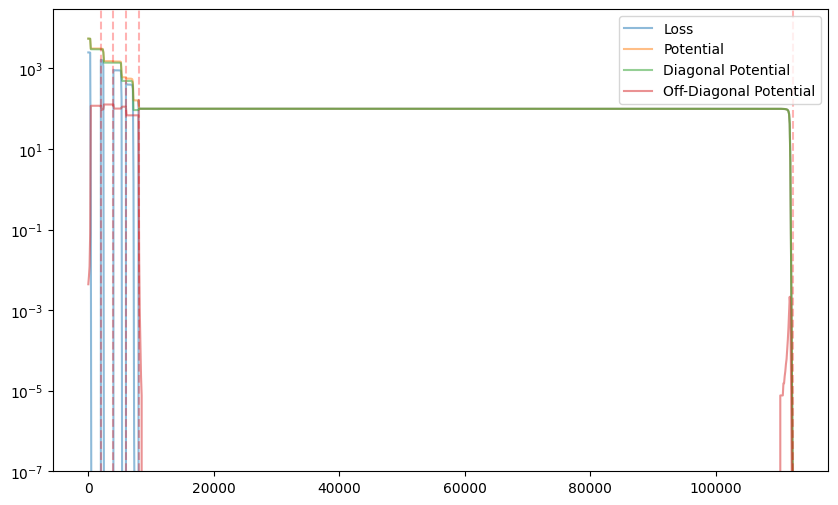

In [10]:
df_stage_flow = pd.DataFrame(stage_flow_rec)
# df_stage_flow = df_stage_flow[df_stage_flow["t"] > 1000]
df_stage_flow["potential"] = df_stage_flow["params"].apply(potential_fn)
df_stage_flow["diag_potential"] = df_stage_flow["params"].apply(
    lambda x: np.sum(np.diag(potential_matrix_fn(x))**2)
)
df_stage_flow["offdiag_potential"] = df_stage_flow["potential"] - df_stage_flow["diag_potential"]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.plot(df["t"], df["potential"], label="Potential")
# ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.plot(df_stage_flow["t"], df_stage_flow["loss"], label="Loss", alpha=0.5)
ax.plot(df_stage_flow["t"], df_stage_flow["potential"], label="Potential", alpha=0.5)
ax.plot(df_stage_flow["t"], df_stage_flow["diag_potential"], label="Diagonal Potential", alpha=0.5)
ax.plot(df_stage_flow["t"], df_stage_flow["offdiag_potential"], label="Off-Diagonal Potential", alpha=0.5)
ax.set_yscale("log")
# ax.set_xscale("log")
ax.legend()

ymin, ymax = set_axis_ylim(ax, ymin_bound=1e-7)
ax.vlines(curr_steps, ymin, ymax, color="r", linestyle="--", alpha=0.3)


Saving file at: ./images/stagewise_dln_plots/plots_20240820/stagewise_dln_idcorrTrue_initoriginTrue_20240820_stagewise_trained.png


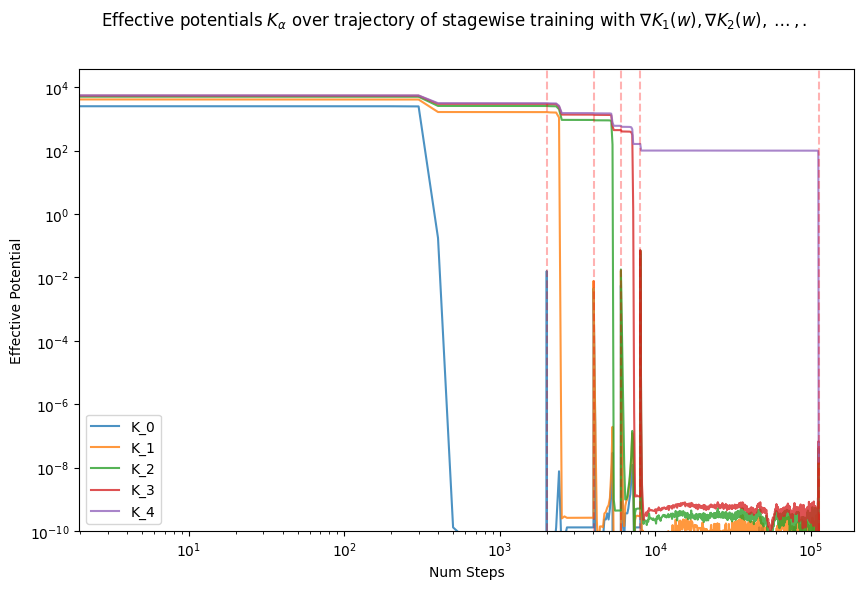

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
# ax.plot(
#     df_stage_flow["t"], 
#     df_stage_flow["potential"], 
#     label="K(w)", 
#     alpha=1
# )


for i, stage_fn in enumerate(stage_potential_fn_list):
    df_stage_flow[f"K_{i}"] = df_stage_flow["params"].apply(stage_fn)
    ax.plot(df_stage_flow["t"], df_stage_flow[f"K_{i}"], "-", label=f"K_{i}", alpha=0.8)


ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Num Steps")
ax.set_ylabel("Effective Potential")


ymin, ymax = set_axis_ylim(ax, ymin_bound=1e-10)
ax.vlines(curr_steps, ymin, ymax, color="r", linestyle="--", alpha=0.3)

fig.suptitle("Effective potentials $K_\\alpha$ over trajectory of stagewise training with $\\nabla K_1(w), \\nabla K_2(w), \dots, $.");

filename = f"{expt_name}_{datetime_str}_stagewise_trained.png"
savefig_fn(fig, filename)

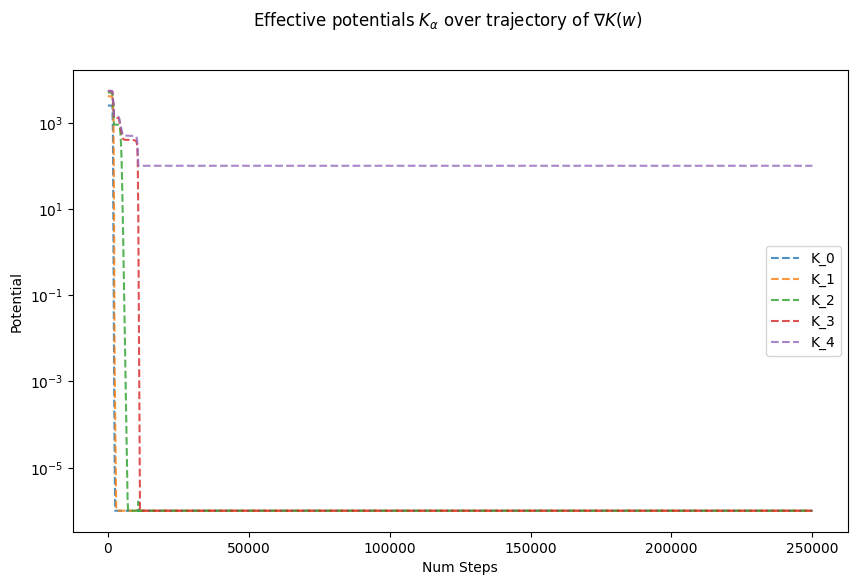

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df = df_flow.copy(deep=True)
ymin_bound = 1e-6

df["potential"] = df["params"].apply(potential_fn)

for i, stage_fn in enumerate(stage_potential_fn_list):
    df[f"K_{i}"] = np.clip(df["params"].apply(stage_fn), a_min=ymin_bound, a_max=np.inf)
    ax.plot(df["t"], df[f"K_{i}"], "--", label=f"K_{i}", alpha=0.8)


ax.set_xlabel("Num Steps")
ax.set_ylabel("Potential")

ax.set_yscale("log")
# ax.set_xscale("log")
ax.legend()

fig.suptitle("Effective potentials $K_\\alpha$ over trajectory of $\\nabla K(w)$");

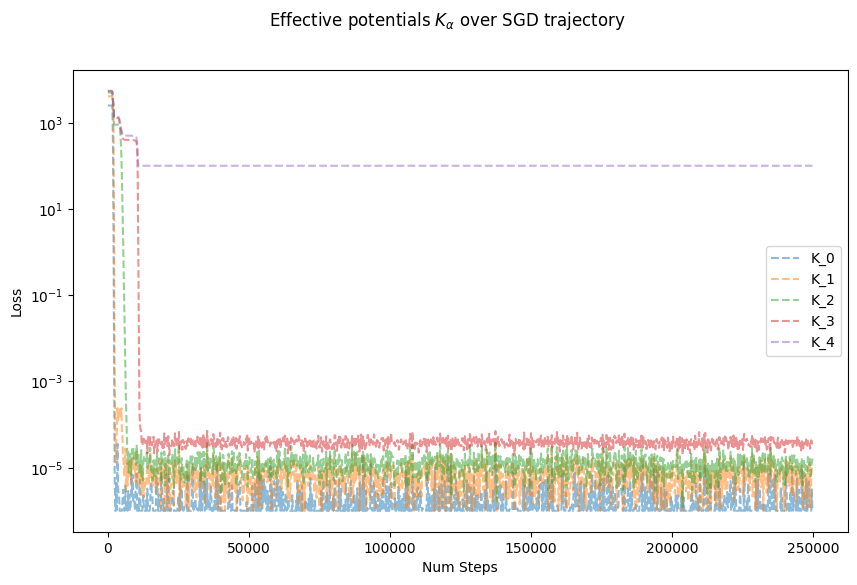

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df = df_sgd.copy(deep=True)

ymin_bound = 1e-6
df["potential"] = df["trained_param"].apply(potential_fn)

for i, stage_fn in enumerate(stage_potential_fn_list):
    df[f"K_{i}"] = np.clip(df["trained_param"].apply(stage_fn), a_min=ymin_bound, a_max=np.inf)
    ax.plot(df["t"], df[f"K_{i}"], "--", label=f"K_{i}", alpha=0.5)


ax.set_xlabel("Num Steps")
ax.set_ylabel("Loss")

ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_xlim(1000, 10000)
# ax.set_ylim(1e-6, 1e3)
ax.legend()

fig.suptitle("Effective potentials $K_\\alpha$ over SGD trajectory");

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91487/3846781385.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


Saving file at: ./images/stagewise_dln_plots/plots_20240820/stagewise_dln_idcorrTrue_initoriginTrue_20240820_pca_trajectory2d.png
Saving file at: ./images/stagewise_dln_plots/plots_20240820/stagewise_dln_idcorrTrue_initoriginTrue_20240820_pca_trajectory3d.png


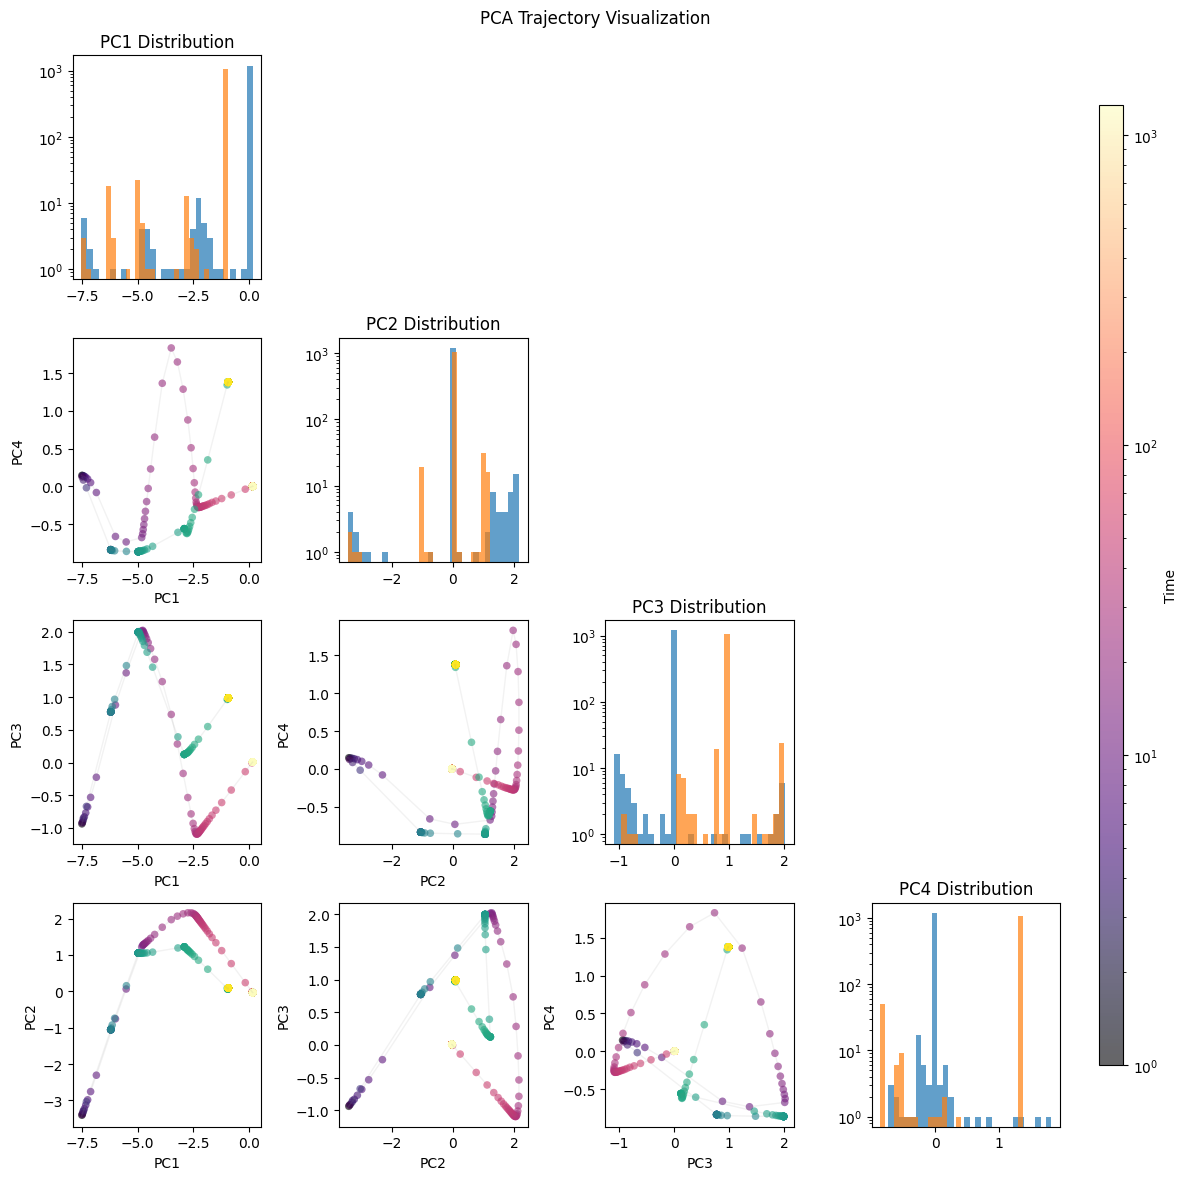

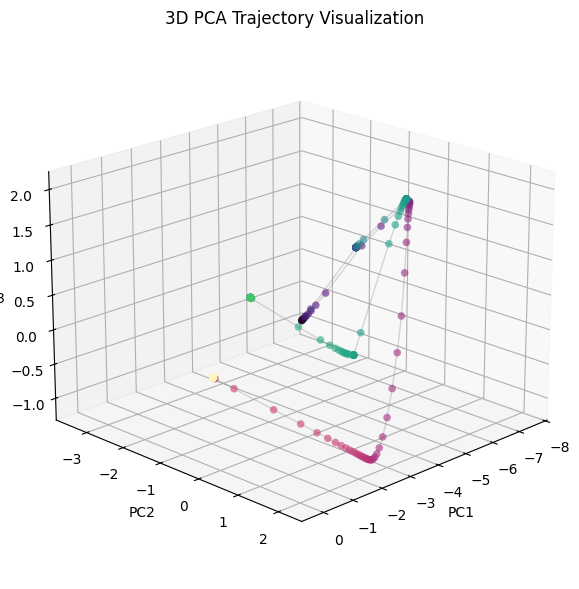

In [14]:
df = df_sgd
param_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df["trained_param"]])
stagewise_flow_trajectory = np.array(
    [jtree.tree_flatten(param)[0] for param in df_stage_flow["params"]]
)




k = 4
pca = PCA(n_components=k)
transformed_trajectory = pca.fit_transform(param_trajectory)
transformed_stagewise_flow_trajectory = pca.transform(stagewise_flow_trajectory)

figsize_factor = 3
logscale_colorbar = True
logscale_hist = True

fig, axes = plt.subplots(k, k, figsize=(figsize_factor*k, figsize_factor*k))
fig.suptitle("PCA Trajectory Visualization")
visualize_pca_trajectory(
    transformed_trajectory, 
    axes, 
    logscale_colorbar=logscale_colorbar, 
    logscale_hist=logscale_hist
)
visualize_pca_trajectory(
    transformed_stagewise_flow_trajectory, 
    axes, 
    logscale_colorbar=logscale_colorbar, 
    logscale_hist=logscale_hist, 
    add_cbar=False, 
    cmap="viridis"
)
savefig_fn(fig, f"{expt_name}_{datetime_str}_pca_trajectory2d.png")


# Create the 3D plot
figsize=(8, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
visualize_pca_trajectory_3d(
    transformed_trajectory, 
    ax, 
    logscale_colorbar=logscale_colorbar, 
    add_cbar=False
)

visualize_pca_trajectory_3d(
    transformed_stagewise_flow_trajectory, 
    ax, 
    logscale_colorbar=logscale_colorbar, 
    add_cbar=False, 
    cmap="viridis"
)

savefig_fn(fig, f"{expt_name}_{datetime_str}_pca_trajectory3d.png")


## Paper plot

Saving file at: ./images/stagewise_dln_plots/plots_20240820/stagewise_dln_idcorrTrue_initoriginTrue_20240820.pdf


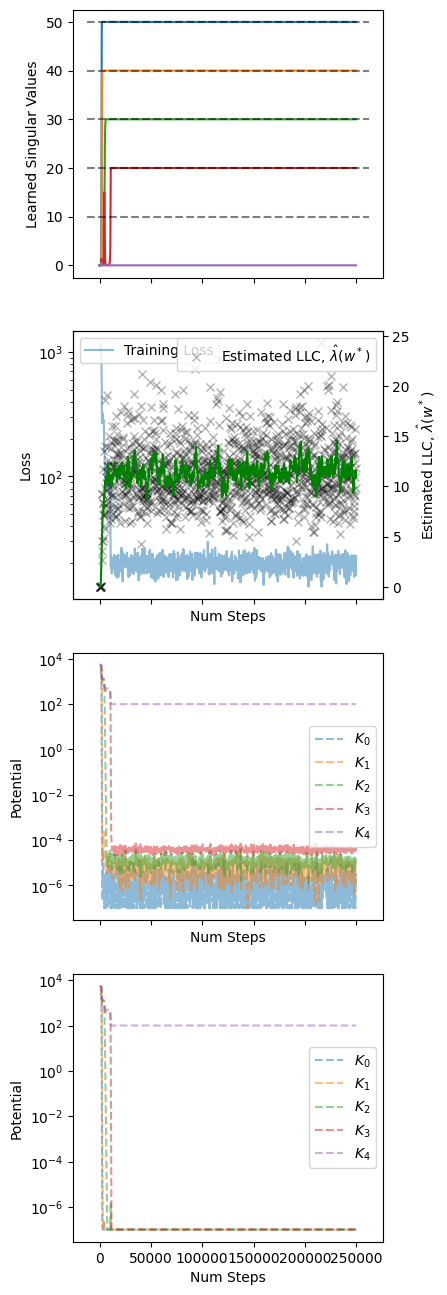

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(4,16), sharex=True)
ymin_bound = 1e-7


df = df_sgd.copy(deep=True)
ax = axes[0]
key = "corrected_total_matrix_diagonals"
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("Learned Singular Values")



ax = axes[1]
ax.plot(df["t"], df["train_loss"], label="Training Loss", alpha=0.5)
ax.set_xlabel("Num Steps")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax.legend(loc="upper left")


if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(df["lambdahat"])
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")




ax = axes[2]
# df["potential"] = df["trained_param"].apply(potential_fn)
# ax.plot(df["t"], df["potential"], label="$K(w)$", alpha=0.5)
for i, stage_fn in enumerate(stage_potential_fn_list):
    df[f"K_{i}"] = np.clip(df["trained_param"].apply(stage_fn), a_min=ymin_bound, a_max=np.inf)
    ax.plot(df["t"], df[f"K_{i}"], "--", label=f"$K_{i}$", alpha=0.5)

ax.set_xlabel("Num Steps")
ax.set_ylabel("Potential")
ax.set_yscale("log")
ax.legend()


ax = axes[3]
df = df_flow.copy(deep=True)
# df["potential"] = df["params"].apply(potential_fn)
# ax.plot(df["t"], df["potential"], label="$K(w)$", alpha=0.5)
for i, stage_fn in enumerate(stage_potential_fn_list):
    df[f"K_{i}"] = np.clip(df["params"].apply(stage_fn), a_min=ymin_bound, a_max=np.inf)
    ax.plot(df["t"], df[f"K_{i}"], "--", label=f"$K_{i}$", alpha=0.5)


ax.set_xlabel("Num Steps")
ax.set_ylabel("Potential")

ax.set_yscale("log")
ax.legend()


filename = f"{expt_name}_{datetime_str}.pdf"
savefig_fn(fig, filename)

# Visualising all 3 trajectories: SGD, $\nabla K(w)$ and stagewise $\nabla K_\alpha(w)$

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91487/3846781385.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make room for colorbar


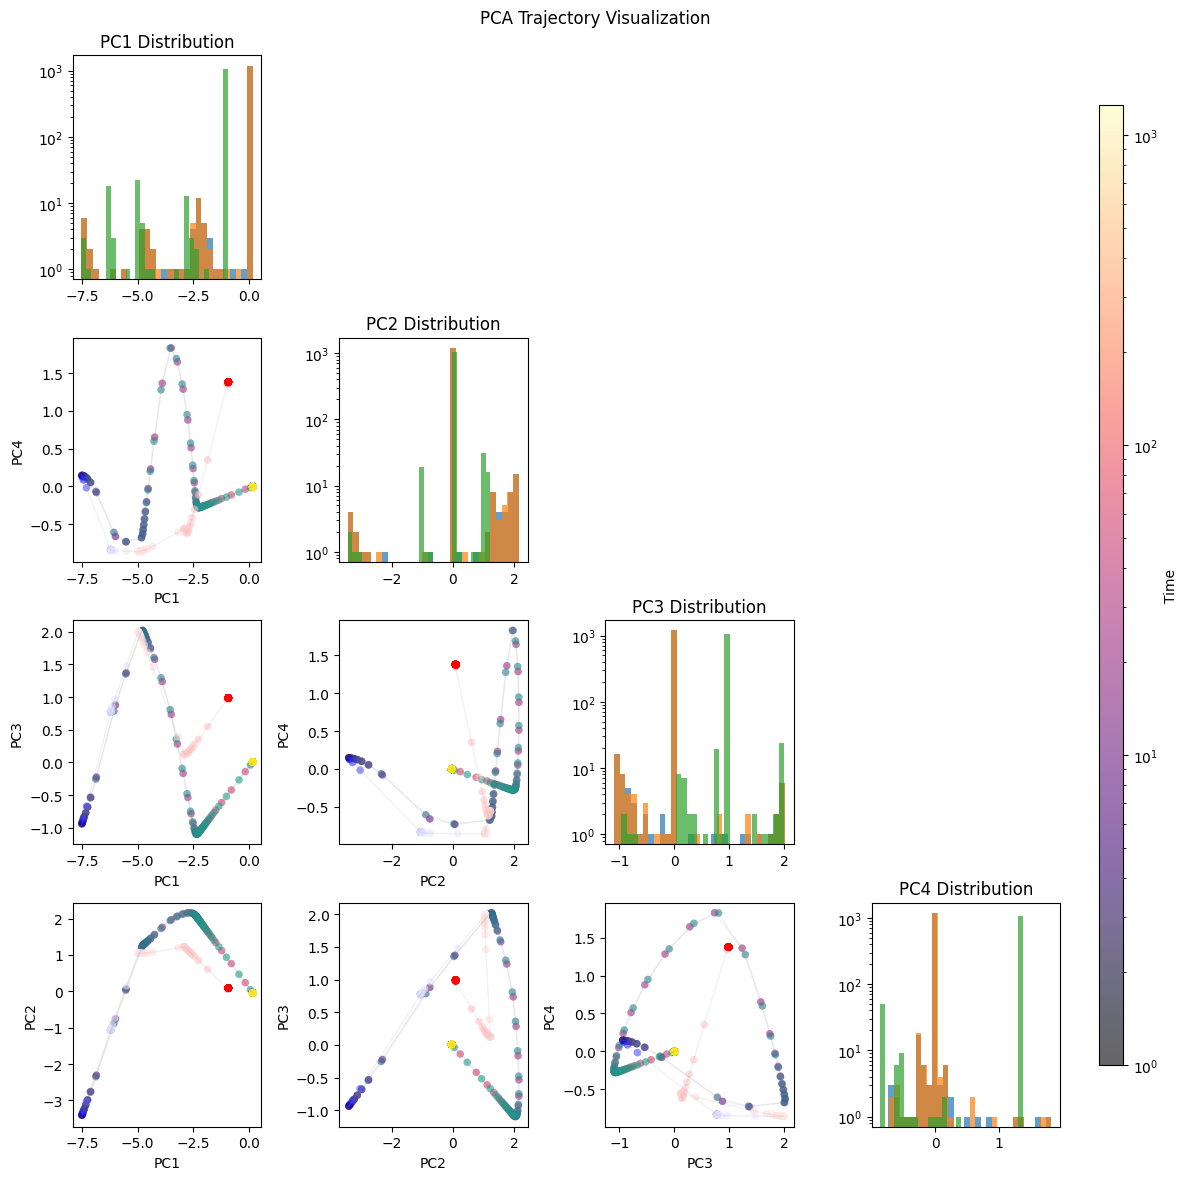

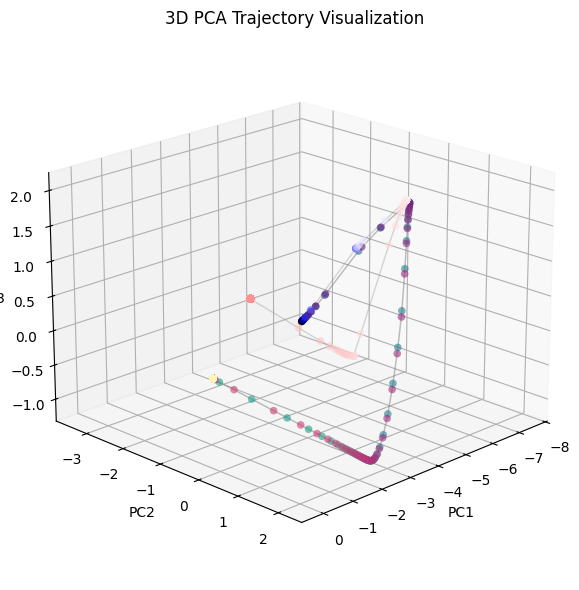

In [16]:


flow_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df_flow["params"]])
param_trajectory = np.array([jtree.tree_flatten(param)[0] for param in df_sgd["trained_param"]])
stagewise_flow_trajectory = np.array(
    [jtree.tree_flatten(param)[0] for param in df_stage_flow["params"]]
)

k = 4
pca = PCA(n_components=k)
transformed_trajectory = pca.fit_transform(param_trajectory)
transformed_flow_trajectory = pca.transform(flow_trajectory)
transformed_stagewise_flow_trajectory = pca.transform(stagewise_flow_trajectory)

figsize_factor = 3
logscale_colorbar = True
logscale_hist = True

fig, axes = plt.subplots(k, k, figsize=(figsize_factor*k, figsize_factor*k))
fig.suptitle("PCA Trajectory Visualization")
visualize_pca_trajectory(
    transformed_trajectory, 
    axes, 
    logscale_colorbar=logscale_colorbar, 
    logscale_hist=logscale_hist
)
visualize_pca_trajectory(
    transformed_flow_trajectory, 
    axes, 
    logscale_colorbar=logscale_colorbar, 
    logscale_hist=logscale_hist, 
    add_cbar=False, 
    cmap="viridis"
)
visualize_pca_trajectory(
    transformed_stagewise_flow_trajectory, 
    axes, 
    logscale_colorbar=logscale_colorbar, 
    logscale_hist=logscale_hist, 
    add_cbar=False, 
    cmap="bwr"
)




# Create the 3D plot
figsize=(8, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection='3d')
visualize_pca_trajectory_3d(
    transformed_trajectory, 
    ax, 
    logscale_colorbar=logscale_colorbar, 
    add_cbar=False
)
visualize_pca_trajectory_3d(
    transformed_flow_trajectory, 
    ax, 
    logscale_colorbar=logscale_colorbar, 
    add_cbar=False, 
    cmap="viridis"
)
visualize_pca_trajectory_3d(
    transformed_stagewise_flow_trajectory, 
    ax, 
    logscale_colorbar=logscale_colorbar, 
    add_cbar=False, 
    cmap="bwr"
)

# LLC estimation

In [17]:

sgld_config_eff_potential = SGLDConfig(
    num_steps=500, 
    epsilon=5e-8, 
    gamma=1.0, 
)
logging_period = 100

do_full_potential_llc_estimation = False

for rec in stage_meta_rec:
    stage = rec["stage"]
    print(
        f"Running SGLD for stage {stage}"
        f"\nFinal loss: {rec['final_loss']}"
    )
    stage_potential_fn = rec["potential_fn"]

    rngkey, subkey = jax.random.split(rngkey)
    itemp = 1 / np.log(num_training_data)
    param_center = rec["final_param"]

    loss_trace, distances, posterior_samples = run_sgld_known_potential(
        subkey, 
        stage_potential_fn, 
        sgld_config_eff_potential, 
        param_center, 
        num_training_data, 
        itemp=itemp, 
        compute_distance=True, 
        verbose=True, 
        logging_period=logging_period
    )
    base_loss = stage_potential_fn(param_center)
    trace_start = min(int(burn_in_prop * len(loss_trace)), len(loss_trace) - 1)
    llc_est = float(np.mean(loss_trace[trace_start:]) - base_loss) * num_training_data * itemp
    
    if do_full_potential_llc_estimation:
        rngkey, subkey = jax.random.split(rngkey)
        full_loss_trace, full_distances, posterior_samples = run_sgld_known_potential(
            subkey, 
            potential_fn, 
            sgld_config_eff_potential, 
            param_center, 
            num_training_data, 
            itemp=itemp, 
            compute_distance=True, 
            verbose=True, 
            logging_period=logging_period
        )
        trace_start = min(int(burn_in_prop * len(full_loss_trace)), len(full_loss_trace) - 1)
        full_llc_est = float(np.mean(full_loss_trace[trace_start:]) - potential_fn(param_center)) * num_training_data * itemp
        rec.update(
            {
                "full_loss_trace": full_loss_trace, 
                "full_distances": full_distances, 
                "full_llc_est": full_llc_est,
            }
        )


    true_matrix = jnp.linalg.multi_dot(
        [jnp.array(param_center[f'deep_linear_network/linear{loc}']['w']) for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
    )
    _, svals, _ = np.linalg.svd(true_matrix)
    print(svals)
    true_rank = np.sum(svals > 1e-1)
    modified_layer_widts = layer_widths.copy()
    modified_layer_widts[-1] = true_rank
    true_lambda, true_multiplicity = true_dln_learning_coefficient(
        true_rank, 
        modified_layer_widts, 
        input_dim=true_rank,
    )
    true_bllc, true_bmultiplicity = true_dln_learning_coefficient(
        true_rank, 
        layer_widths, 
        input_dim=in_out_dim,
    )

    print(
        f"LLC: {llc_est:.2f}, "
        + (f"LLC full: {full_llc_est:.2f}, " if do_full_potential_llc_estimation else "")
        + f"True $K_\\alpha$ LLC: {true_lambda:.3f}, "
        + f"True Rank: {true_rank}, "
        + f"True bLLC: {true_bllc:.3f}, "
    )

    rec.update(
        {
            "loss_trace": loss_trace, 
            "distances": distances, 
            "llc_est": llc_est, 
            "true_lambda": true_lambda,
            "true_multiplicity": true_multiplicity,
            "true_rank": true_rank, 
            "true_bllc": true_bllc,
            "true_bmultiplicity": true_bmultiplicity,
        }
    )


Running SGLD for stage 1
Final loss: 1.4551915228366852e-11
Step 0, loss: 1.4551915228366852e-11
Step 100, loss: 3003.5712890625
Step 200, loss: 2999.76171875
Step 300, loss: 2998.80322265625
Step 400, loss: 2997.9931640625
[5.1173916e+01 5.1667169e-02 1.3658824e-02 2.7133897e-03 5.3828680e-06]
LLC: 3254386.39, True $K_\alpha$ LLC: 0.500, True Rank: 1, True bLLC: 9.500, 
Running SGLD for stage 2
Final loss: 2.6453050860908434e-10
Step 0, loss: 2.6453050860908434e-10
Step 100, loss: 0.0017314982833340764
Step 200, loss: 0.0011742929928004742
Step 300, loss: 0.0005443776026368141
Step 400, loss: 0.00013831227261107415
[5.0959618e+01 4.0382740e+01 1.2974565e-02 2.6566922e-03 2.8092014e-05]
LLC: 2.65, True $K_\alpha$ LLC: 2.000, True Rank: 2, True bLLC: 11.000, 
Running SGLD for stage 3
Final loss: 4.4603548632338175e-10
Step 0, loss: 4.4603548632338175e-10
Step 100, loss: 0.005556135904043913
Step 200, loss: 0.003865709761157632
Step 300, loss: 0.007644216530025005
Step 400, loss: 0.00353

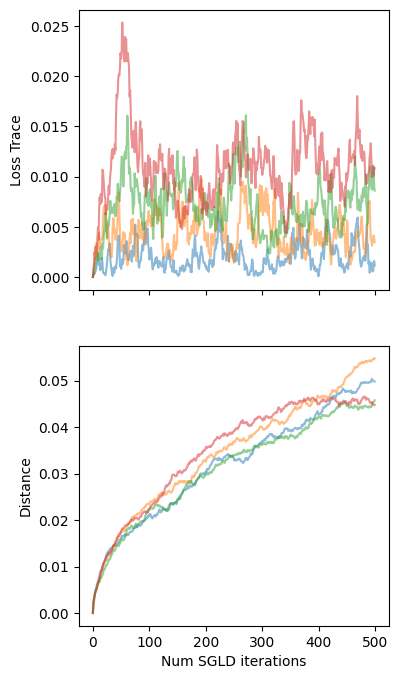

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(4,8), sharex=True)
for rec in stage_meta_rec[1:]:
    loss_trace = jnp.array(rec["loss_trace"]) - rec["final_loss"]
    distances = rec["distances"]
    ax = axes[0]
    ax.plot(loss_trace, alpha=0.5)
    ax.set_ylabel("Loss Trace")

    ax = axes[1]
    ax.plot(distances, alpha=0.5)
    ax.set_ylabel("Distance")
    ax.set_xlabel("Num SGLD iterations")

Saving file at: ./images/stagewise_dln_plots/plots_20240820/stagewise_dln_idcorrTrue_initoriginTrue_20240820_stagewise_llc_estimation.png


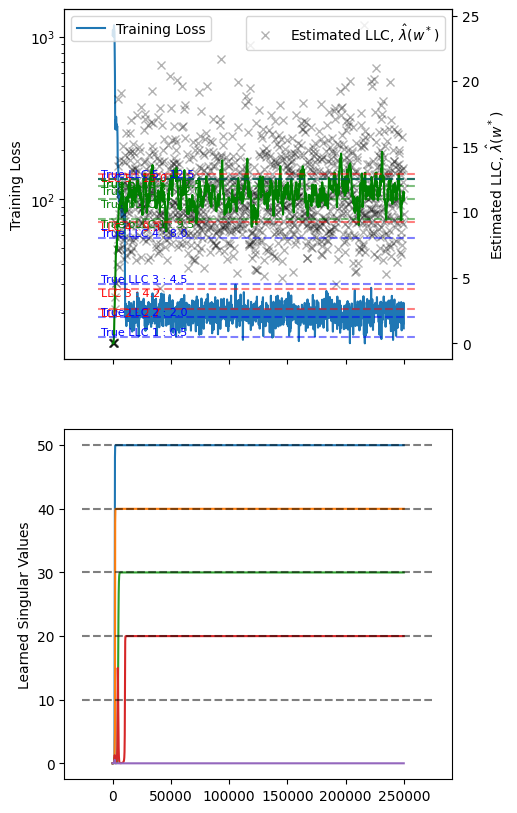

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
ax = axes[0]
df = df_sgd
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    ax.plot(df["t"], np.clip(df["lambdahat"], a_min=0, a_max=np.inf), "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(df["lambdahat"])
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")

xmin, xmax = ax.get_xlim()
for j, rec in enumerate(stage_meta_rec):
    if j != 0:
        llc_est = rec["llc_est"]
        ax.hlines(llc_est, xmin, xmax, color="r", linestyle="--", alpha=0.5)
        ax.text(
            xmin + 0.01 * (xmax - xmin), 
            rec["llc_est"], 
            f"LLC {rec['stage']} : {rec['llc_est']:.1f}", 
            verticalalignment="top", 
            color="r", 
            fontsize=8,
        )
    if "full_llc_est" in rec and False:
        full_llc_est = rec["full_llc_est"]
        ax.hlines(full_llc_est, xmin, xmax, color="b", linestyle="--", alpha=0.5)

    if "true_lambda" in rec:
        true_lambda = rec["true_lambda"]
        ax.hlines(true_lambda, xmin, xmax, color="b", linestyle="--", alpha=0.5)
        ax.text(
            xmin + 0.01 * (xmax - xmin), 
            true_lambda, 
            f"True LLC {rec['stage']} : {true_lambda:.1f}", 
            verticalalignment="bottom", 
            color="b", 
            fontsize=8,
        )
    if "true_bllc" in rec:
        true_bllc = rec["true_bllc"]
        ax.hlines(true_bllc, xmin, xmax, color="g", linestyle="--", alpha=0.5)
        ax.text(
            xmin + 0.01 * (xmax - xmin), 
            true_bllc, 
            f"True bLLC {rec['stage']} : {true_bllc:.1f}", 
            verticalalignment="top", 
            color="g", 
            fontsize=8,
        )

ax = axes[1]
df = df_sgd.copy(deep=True)
key = "corrected_total_matrix_diagonals"
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("Learned Singular Values")


savefig_fn(fig, f"{expt_name}_{datetime_str}_stagewise_llc_estimation.png")


# Essential Dynamics

# TODO
- [ ] Add percent variance to PCA titles. 
- [x] Gradient flow on stagewise potential. 
- [x] SGD on stagewise distribution. 

# Loss curve vs power law spectrum decay

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_91487/270054862.py:30: RuntimeWarning: divide by zero encountered in log
  log_losses = np.log(losses)
/Users/edmund/.local/share/virtualenvs/neural_network_stagewise_learning-iEdHgy9r/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


Alpha: 2.000, Exponent: nan, const: nan
Alpha: 2.421, Exponent: nan, const: nan
Alpha: 2.842, Exponent: nan, const: nan
Alpha: 3.263, Exponent: nan, const: nan
Alpha: 3.684, Exponent: nan, const: nan
Alpha: 4.105, Exponent: nan, const: nan
Alpha: 4.526, Exponent: nan, const: nan
Alpha: 4.947, Exponent: nan, const: nan
Alpha: 5.368, Exponent: nan, const: nan
Alpha: 5.789, Exponent: nan, const: nan
Alpha: 6.211, Exponent: nan, const: nan
Alpha: 6.632, Exponent: nan, const: nan
Alpha: 7.053, Exponent: nan, const: nan
Alpha: 7.474, Exponent: -17.6204, const: 9156914980824841204315506606902638328402398567769534607021312326333672260541809845574274748301804721668096.0000
Alpha: 7.895, Exponent: -7.6257, const: 1601976255564963055717392578117724274688.0000
Alpha: 8.316, Exponent: -4.0680, const: 3081613739742292.0000
Alpha: 8.737, Exponent: -2.8480, const: 28590120.0776
Alpha: 9.158, Exponent: -2.3852, const: 30020.7435
Alpha: 9.579, Exponent: -2.1756, const: 1461.3535
Alpha: 10.000, Exponent:

Text(0.5, 0.98, 'lr=0.100, spectral deacay$=100.0/f^\\alpha$, fmin=0.1, fmax=10.0, num_terms=500')

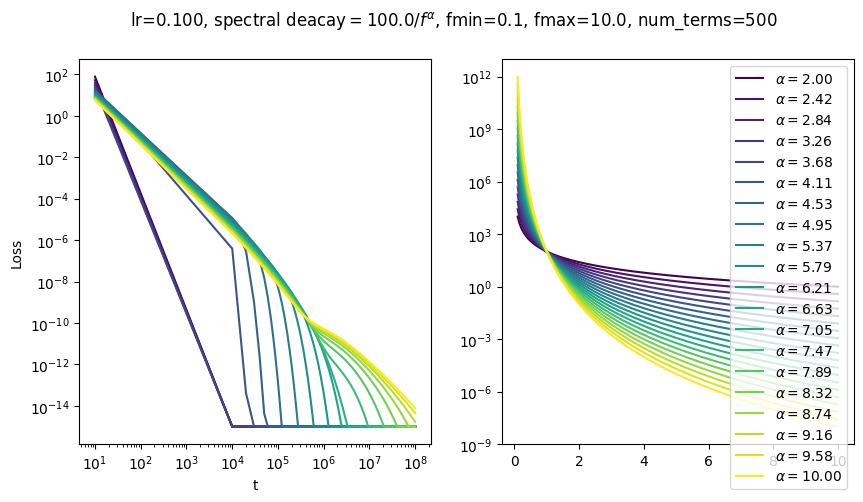

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def a_i(t, s_i, lambda_param, a_0=1e-5):
    """
    Logistic function for a_i(t)
    """
    return s_i / (1 + (s_i / a_0 - 1) * np.exp(-lambda_param * s_i * t))

def singular_val_func(x, alpha, const=2.0):
    """
    Spectrum decay function for s_i
    """
    return const / (x**alpha)

def loss_function(ts, singular_values, lambda_param, const=0.01):
    """
    Compute the loss function
    """
    m = np.vstack([(a_i(ts, s, lambda_param) - s)**2 for s in singular_values])
    return np.sum(m, axis=0) * const

def calculate_power_law_exponent(ts, losses):
    """
    Calculate the power law exponent by performing linear regression
    on log(losses) vs log(ts)
    """
    log_ts = np.log(ts)
    log_losses = np.log(losses)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_ts, log_losses)
    return slope, intercept, r_value**2


ts = np.linspace(10, 1e8, 10000)
lambda_param = 0.1
num_terms = 500
fmin = 0.1
fmax = 10.0
freqs = np.linspace(fmin, fmax, num_terms)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
cmap = plt.get_cmap("viridis")

amin = 2.0
amax = 10.0
const = 100.0
for alpha in np.linspace(amin, amax, 20):
    # singular_values = np.array([singular_val_func(i, alpha, const=5.0) for i in range(1, num_terms + 1)])
    singular_values = singular_val_func(freqs, alpha, const=const)
    losses = loss_function(ts, singular_values, lambda_param)
    exponent, intercept, r2 = calculate_power_law_exponent(ts, losses)
    print(f"Alpha: {alpha:.3f}, Exponent: {exponent:.4f}, const: {np.exp(intercept):.4f}")
    losses = np.clip(losses, a_min=1e-15, a_max=np.inf)
    c = cmap((alpha - amin) / (amax - amin))
    ax = axes[0]
    ax.plot(ts, losses, label=f"$\\alpha={alpha:.3f}$", c=c)

    ax = axes[1]
    ax.plot(freqs, singular_values, label=f"$\\alpha={alpha:.2f}$", c=c)

ax = axes[0]
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("t")
ax.set_ylabel("Loss")

ax = axes[1]
ax.legend()
ax.set_yscale("log")

fig.suptitle(
    f"lr={lambda_param:.3f}, "
    f"spectral deacay$={const}/f^\\alpha$, "
    f"fmin={fmin}, fmax={fmax}, num_terms={num_terms}"
)
